In [1]:
import csv
import gzip
import os
import matplotlib as mpl
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
matrix_dir = "genesrna"
mat = pd.read_csv("genesrna/rnamat.csv")
datafile = 'dataset2.count.txt'
df = pd.read_csv(datafile, sep='\t')
df = df.set_index('Gene.Symbol')
cells = list(df.columns.values)
mat = np.array(mat)
features_path = os.path.join(matrix_dir, "features.txt")
annotation  = pd.read_csv(features_path,sep='\t',header=None)
annotation.columns = ['gene_names']
barcodes_path = os.path.join(matrix_dir, "barcodes.txt")
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
mat = mat.T 
print('compiled!')
mat.shape

compiled!


(626, 22241)

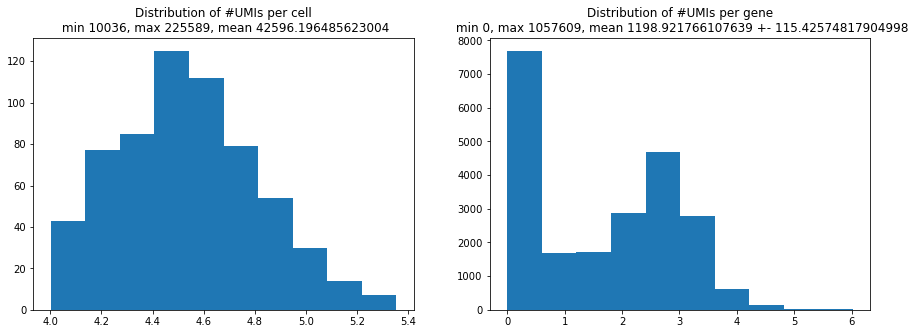

In [3]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis=1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))));

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1));
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +- {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))));
plt.savefig('DATASET2: PEAKING THE DATA.png')


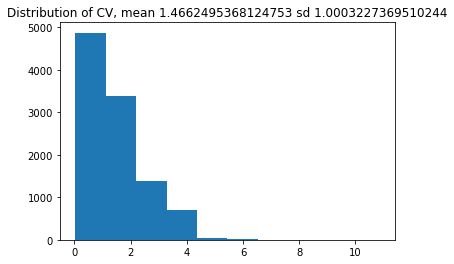

In [4]:
low_expr_thr = 100
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
plt.hist(CV)
plt.title('Distribution of CV, mean {} sd {}'.format(np.mean(CV), np.std(CV)**0.5))
plt.savefig('DATASET2: CV PLOT.png')

(626, 3951)


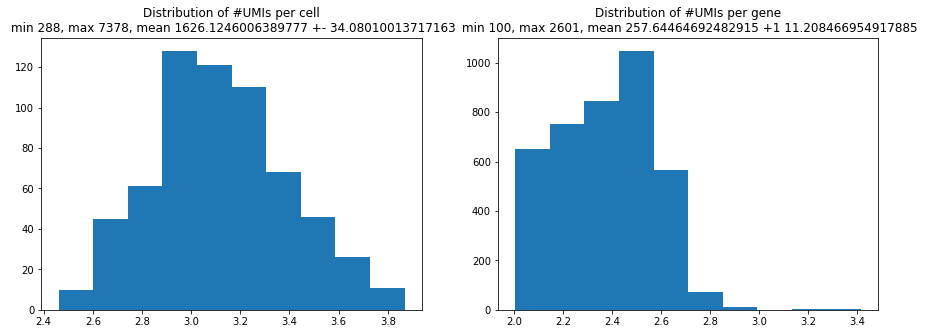

In [5]:
mat = mat[:, CV >= 1.5]
print(mat.shape)
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis = 1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {} +- {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))))

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1))
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +1 {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))))
plt.savefig('DATASET2: FILTERING PLOTS.png')

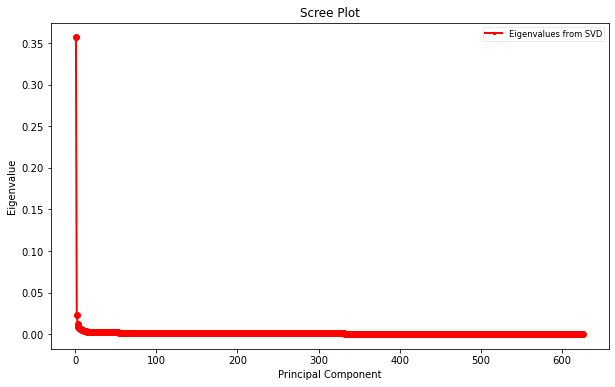

In [6]:
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
test = mat[:len(mat), :len(mat)]
U, S, V = np.linalg.svd(mat) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(10, 6))
sing_vals = np.arange(len(mat)) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=mpl.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
fig.savefig('DATASET2: SCREE PLOT.png')
#leg.draggable(state=True)

626
626
626


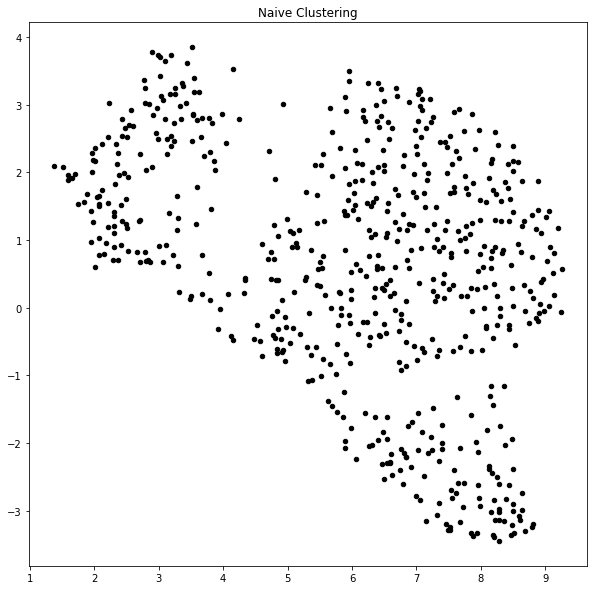

In [7]:
pca = PCA(n_components=100)
pca.fit(mat)
mat_reduce=pca.transform(mat)
true_indices = {}
true_coords = {}
with open('mat_reduce.txt', 'w') as f:
    for i in mat_reduce:
        f.write("%s\n" % i)
embedding = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='euclidean').fit_transform(mat_reduce)
print(len(embedding))
for i in range (0, len(embedding)):
    true_indices.update({str(embedding[i]):cells[i]})
    true_coords.update({cells[i]:str(embedding[i]).strip()})
with open('embedding.txt', 'w') as f:
    for e in embedding:
        f.write("%s\n" % e)
plt.figure(figsize=(10, 10))
print(len(true_coords))
print(len(true_indices))
plt.scatter(embedding[:,0],embedding[:,1], s=20.0, color='black')
plt.title('Naive Clustering')
plt.savefig('DATASET2: NAIVE CLUSTERING.png')

AffinityPropagation
[142 121 125 106 132]
MeanShift
[454 172]
SpectralClustering
[145 370 111]
Ward
[374 147 105]
AgglomerativeClustering
[  3 622   1]
DBSCAN
[315 124   4  25   9  92   5   4]
Birch
[382 142 102]
GaussianMixture
[364 136 126]


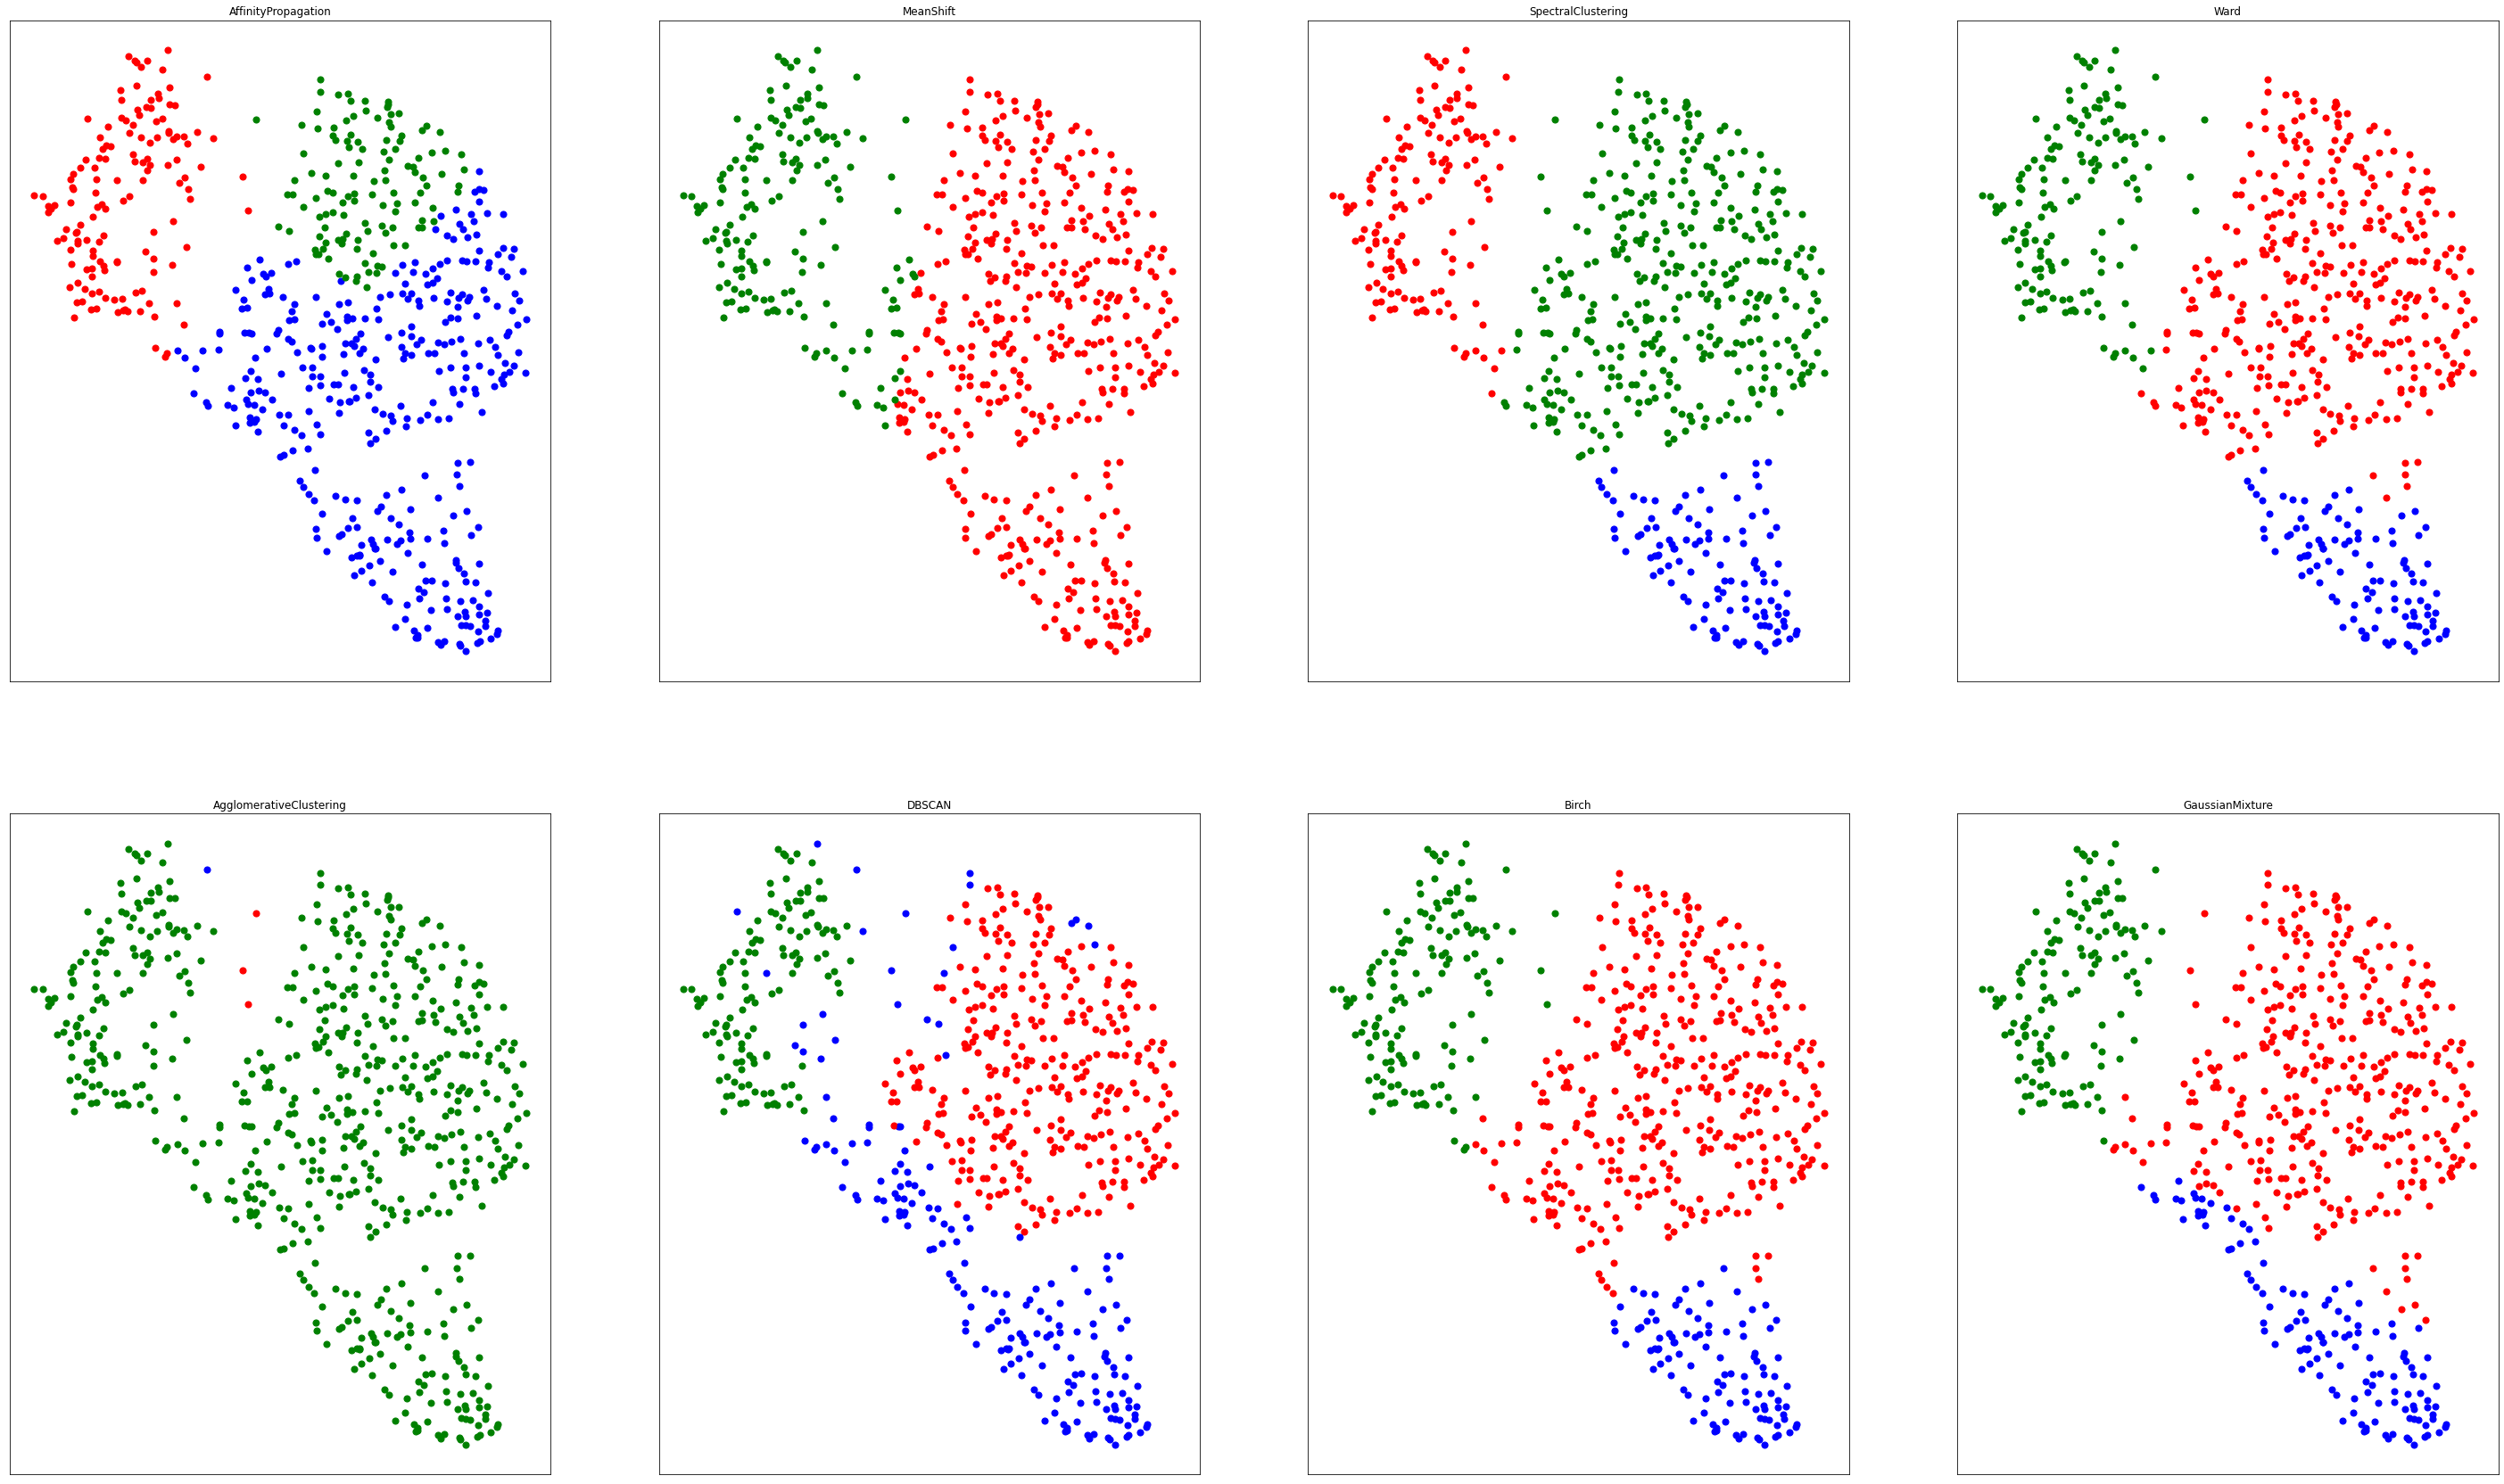

In [9]:
params = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference':-200, 'n_neighbors':10, 'n_clusters':3}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
clustering_algorithms = (
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm))
#now plot everything
f, ax = plt.subplots(2, 4, figsize=(50,30))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['black', 'red', 'green']),
                                    int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    
    colors = np.append(colors, ["#000000"])
    for i in range(len(embedding)):
        if y_pred[i] == 0:
            color = 'red'
        elif y_pred[i] == 1:
            color = 'green'
        else: 
            color = 'blue'
        ax[idx//4, idx%4].scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=50, color=color)
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//4, idx%4].set_xticks(())
    ax[idx//4, idx%4].set_yticks(())
    ax[idx//4, idx%4].set_title(name)
    #Store the labels
    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    #print(labels)
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])
    print('{}'.format(name))
    print(counts)
    #print(embedding)
plt.savefig('DATASET2: ALL CLUSTERS.png')

In [10]:
'''birch.fit(embedding)
birch_coords = {}
y_pred = birch.labels_.astype(np.int)
colors = np.append(colors, ["#000000"])
for i in range(len(embedding)):
    birch_coords.update({str(embedding[i]):y_pred[i]})
    if y_pred[i] == 0:
        color = 'red'
    elif y_pred[i] == 1:
        color = 'green'
    else: 
        color = 'blue'
    plt.scatter(embedding[i-1:i, 0], embedding[i-1:i, 1], s=4, color=color)
print(birch_coords)
true_labels = {}
for i in birch_coords:
    true_labels.update({true_indices[i]:birch_coords[i]})
print(true_labels)'''

def FindTrueLabels(algorithm):
    algorithm_coords = {}
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    for i in range(len(embedding)):
#         if y_pred[i] == 0:
#             color = 'red'
#         elif y_pred[i] == 1:
#             color = 'green'
#         else: 
#             color = 'blue'
#         plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=color)
        algorithm_coords.update({str(embedding[i]):y_pred[i]})
        
    true_labels = {}
    for i in algorithm_coords:
        true_labels.update({true_indices[i]:algorithm_coords[i]})
    return true_labels

print(len(FindTrueLabels(birch)))

626


In [11]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

In [ ]:
from hashlib import sha1

from numpy import all, array, uint8


class hashable(object):
    r'''Hashable wrapper for ndarray objects.

        Instances of ndarray are not hashable, meaning they cannot be added to
        sets, nor used as keys in dictionaries. This is by design - ndarray
        objects are mutable, and therefore cannot reliably implement the
        __hash__() method.

        The hashable class allows a way around this limitation. It implements
        the required methods for hashable objects in terms of an encapsulated
        ndarray object. This can be either a copied instance (which is safer)
        or the original object (which requires the user to be careful enough
        not to modify it).
    '''
    def __init__(self, wrapped, tight=False):
        r'''Creates a new hashable object encapsulating an ndarray.

            wrapped
                The wrapped ndarray.

            tight
                Optional. If True, a copy of the input ndaray is created.
                Defaults to False.
        '''
        self.__tight = tight
        self.__wrapped = array(wrapped) if tight else wrapped
        self.__hash = int(sha1(wrapped.view(uint8)).hexdigest(), 16)

    def __eq__(self, other):
        return all(self.__wrapped == other.__wrapped)

    def __hash__(self):
        return self.__hash

    def unwrap(self):
        r'''Returns the encapsulated ndarray.

            If the wrapper is "tight", a copy of the encapsulated ndarray is
            returned. Otherwise, the encapsulated ndarray itself is returned.
        '''
        if self.__tight:
            return array(self.__wrapped)

        return self.__wrapped

In [12]:

def DataCollectionP(algorithm, cluster_1, cluster_2, cluster_3, results):
    labels = FindTrueLabels(algorithm)
    num1 = []
    num2 = []
    num3 = []
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    truthnum1 = {}
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        else:
            barcodes3.update({i:labels[i]})

    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
        
        
    g1 = open('G1Cells.txt').readlines()
    g1_line = []
    for lines in g1:
        g1_line.append(lines)
    g2m = open('G2MCells.txt').readlines()
    g2m_line = []
    for lines in g2m:
        g2m_line.append(lines)
    s = open('SCells.txt').readlines()
    s_line = []
    

    res = open(results, "w")

    g1count = 0
    g2mcount = 0
    scount = 0

    g1count2 = 0
    g2mcount2 = 0
    scount2 = 0

    g1count3 = 0
    g2mcount3 = 0
    scount3 = 0
    
    correctNum = 0
    
    for lines in s:
        s_line.append(lines)
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in g1_line:
            if i == j:
                g1count = g1count + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'white'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'black'})
    
    res.write("G1 Count Cluster 1: \n")
    res.write(str(g1count/(len(cluster1_line))) + " \n")
    res.write(str(g1count) + " \n")
    for x in cluster1_line:
        for y in g2m_line:
            if x == y:
                g2mcount = g2mcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'orange'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    
    res.write("G2M Count Cluster 1: \n")
    res.write(str(g2mcount/(len(cluster1_line))) + "\n")
    res.write(str(g2mcount) + "\n")
    for i in cluster1_line:
        for j in s_line:
            if i == j:
                scount = scount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'yellow'})

                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    
    res.write("S Count Cluster 1: \n")
    res.write(str(scount/(len(cluster1_line))) + "\n")
    res.write(str(scount) + "\n")
    res.write("\n")
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in g1_line:
            if i == j:
                g1count2 = g1count2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'green'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    
    res.write("G1 Count Cluster 2:" + "\n")
    res.write(str(g1count2/(len(cluster2_line))) + "\n")
    res.write(str(g1count2) + "\n")
    for i in cluster2_line:
        for j in g2m_line:
            if i == j:
                g2mcount2 = g2mcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'blue'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'black'})
        
    res.write("G2M Count Cluster 2:" + "\n")
    res.write(str(g2mcount2/(len(cluster2_line))) + "\n")
    res.write(str(g2mcount2) + "\n")
    for i in cluster2_line:
        for j in s_line:
            if i == j:
                scount2 = scount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'violet'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    res.write("S Count Cluster 2: \n")
    res.write(str(scount2/(len(cluster2_line))) + "\n")
    res.write(str(scount2) + "\n")
    res.write("\n")
    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in g1_line:
            if i == j:
                g1count3 = g1count3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'purple'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'}
    res.write("G1 Count Cluster 3:" + "\n")
    res.write(str(g1count3/(len(cluster3_line))) + "\n")
    res.write(str(g1count3) + "\n")
    for i in cluster3_line:
        for j in g2m_line:
            if i == j:
                g2mcount3 = g2mcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'pink'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
   
    res.write("G2M Count Cluster 3:" + "\n")
    res.write(str(g2mcount3/(len(cluster3_line))) + "\n")
    res.write(str(g2mcount3) + "\n")
    for i in cluster3_line:
        for j in s_line:
            if i == j:
                scount3 = scount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'grey'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'black'})
    print(algorithm)
    print(len(cluster3_line))
    
    if max(len(cluster1_line), len(cluster2_line), len(cluster3_line)) == len(cluster1_line):
        print("here 1")
        if(scount >= g1count and scount >= g2mcount):
            for i in truthnum1:
                if truthnum1[i] == 'yellow':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'white' or truthnum1[i] == 'orange':
                    truthnum1[i] = 'red'
        elif(g1count >= scount and g1count >= g2mcount):
            for i in truthnum1:
                if truthnum1[i] == 'white':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'yellow' or truthnum1[i] == 'orange':
                    truthnum1[i] = 'red'
        else:
            for i in truthnum1:
                if truthnum1[i] == 'orange':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'white' or truthnum1[i] == 'yellow':
                    truthnum1[i] = 'red'
        
        if(scount2 >= g1count2 and scount2 >= g2mcount2):
            for i in truthnum1:
                if truthnum1[i] == 'green':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'violet' or truthnum1[i] == 'blue':
                    truthnum1[i] = 'red'
        elif(g1count2 >= scount2 and g1count2 >= g2mcount2):
            for i in truthnum1:
                if truthnum1[i] == 'violet':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'green' or truthnum1[i] == 'blue':
                    truthnum1[i] = 'red'
        else:
            for i in truthnum1:
                if truthnum1[i] == 'blue':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'violet' or truthnum1[i] == 'green':
                    truthnum1[i] = 'red'
            
        if(scount3 >= g1count3 and scount3 >= g2mcount3):
            for i in truthnum1:
                if truthnum1[i] == 'purple':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'pink' or truthnum1[i] == 'grey':
                    truthnum1[i] = 'red'
        elif(g1count3 >= scount3 and g1count3 >= g2mcount3):
            for i in truthnum1:
                if truthnum1[i] == 'grey':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'purple' or truthnum1[i] == 'pink':
                    truthnum1[i] = 'red'
        else:
            for i in truthnum1:
                if truthnum1[i] == 'pink':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'purple' or truthnum1[i] == 'grey':
                    truthnum1[i] = 'red'
            
    elif max(len(cluster1_line), len(cluster2_line), len(cluster3_line)) == len(cluster2_line):
        print("here 2")   
        if(scount2 >= g1count2 and scount2 >= g2mcount2):
            for i in truthnum1:
                if truthnum1[i] == 'violet':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'green' or truthnum1[i] == 'blue':
                    truthnum1[i] = 'red'
        elif(g1count2 >= scount2 and g1count2 >= g2mcount2):
            for i in truthnum1:
                if truthnum1[i] == 'green':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'violet' or truthnum1[i] == 'blue':
                    truthnum1[i] = 'red'
        else:
            for i in truthnum1:
                if truthnum1[i] == 'blue':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'violet' or truthnum1[i] == 'green':
                    truthnum1[i] = 'red'
        
        if(scount >= g1count and scount >= g2mcount):
            for i in truthnum1:
                if truthnum1[i] == 'white':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'yellow' or truthnum1[i] == 'orange':
                    truthnum1[i] = 'red'
        elif(g1count >= scount and g1count >= g2mcount):
            for i in truthnum1:
                if truthnum1[i] == 'yellow':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'white' or truthnum1[i] == 'orange':
                    truthnum1[i] = 'red'
        else:
            for i in truthnum1:
                if truthnum1[i] == 'orange':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'white' or truthnum1[i] == 'yellow':
                    truthnum1[i] = 'red'
        if(scount3 >= g1count3 and scount3 >= g2mcount3):
            for i in truthnum1:
                if truthnum1[i] == 'purple':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'pink' or truthnum1[i] == 'grey':
                    truthnum1[i] = 'red'
        elif(g1count3 >= scount3 and g1count3 >= g2mcount3):
            for i in truthnum1:
                if truthnum1[i] == 'grey':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'purple' or truthnum1[i] == 'pink':
                    truthnum1[i] = 'red'
        else:
            for i in truthnum1:
                if truthnum1[i] == 'pink':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'purple' or truthnum1[i] == 'grey':
                    truthnum1[i] = 'red'

    elif max(len(cluster1_line), len(cluster2_line), len(cluster3_line)) == len(cluster3_line):
        print("here 3")
        if(scount3 >= g1count3 and scount3 >= g2mcount3):
            for i in truthnum1:
                if truthnum1[i] == 'grey':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'pink' or truthnum1[i] == 'purple':
                        truthnum1[i] = 'red'
        elif(g1count3 >= scount3 and g1count3 >= g2mcount3):
            for i in truthnum1:
                if truthnum1[i] == 'purple':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'grey' or truthnum1[i] == 'pink':
                    truthnum1[i] = 'red'
        else:
            for i in truthnum1:
                if truthnum1[i] == 'pink':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'purple' or truthnum1[i] == 'grey':
                    truthnum1[i] = 'red'
        
        if(scount >= g1count and scount >= g2mcount):
            for i in truthnum1:
                if truthnum1[i] == 'white':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'yellow' or truthnum1[i] == 'orange':
                    truthnum1[i] = 'red'
        elif(g1count >= scount and g1count >= g2mcount):
            for i in truthnum1:
                if truthnum1[i] == 'yellow':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'white' or truthnum1[i] == 'orange':
                    truthnum1[i] = 'red'
        else:
            for i in truthnum1:
                if truthnum1[i] == 'orange':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'white' or truthnum1[i] == 'yellow':
                    truthnum1[i] = 'red'
        if(scount2 >= g1count2 and scount2 >= g2mcount2):
            for i in truthnum1:
                if truthnum1[i] == 'green':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'violet' or truthnum1[i] == 'blue':
                    truthnum1[i] = 'red'
        elif(g1count2 >= scount2 and g1count2 >= g2mcount2):
            for i in truthnum1:
                if truthnum1[i] == 'violet':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'green' or truthnum1[i] == 'blue':
                    truthnum1[i] = 'red'
        else:
            for i in truthnum1:
                if truthnum1[i] == 'blue':
                    truthnum1[i] = 'black'
                elif truthnum1[i] == 'violet' or truthnum1[i] == 'green':
                    truthnum1[i] = 'red'             
    for i in truthnum1:
        if truthnum1[i]=='black':
            correctNum = correctNum + 1
    correctNum = (correctNum/626) * 100
    incorrectNum = 100-correctNum
    res.write("S Count Cluster 3:" + "\n")
    res.write(str(scount3/(len(cluster3_line))) + "\n")
    res.write(str(scount3) + "\n")
    res.write("\n")
    res.write(json.dumps(truthnum1))
    res.write("")
    return truthnum1, correctNum, incorrectNum

In [13]:
import json
def DataCollection(algorithm, cluster_1, cluster_2, cluster_3, results):
    
    labels = FindTrueLabels(algorithm)
    
    num1 = []
    num2 = []
    num3 = []
    
#     num1 = ClusterIndicesNumpy(0, algorithm.labels_)
#     num2 = ClusterIndicesNumpy(1, algorithm.labels_)
#     num3 = ClusterIndicesNumpy(2, algorithm.labels_) 
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    truthnum1 = {}
    truthnum2 = {}
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        else:
            barcodes3.update({i:labels[i]})

    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
        
        
    g1 = open('G1Cells.txt').readlines()
    g1_line = []
    for lines in g1:
        g1_line.append(lines)
    g2m = open('G2MCells.txt').readlines()
    g2m_line = []
    for lines in g2m:
        g2m_line.append(lines)
    s = open('SCells.txt').readlines()
    s_line = []
    

    res = open(results, "w")

    g1count = 0
    g2mcount = 0
    scount = 0

    g1count2 = 0
    g2mcount2 = 0
    scount2 = 0

    g1count3 = 0
    g2mcount3 = 0
    scount3 = 0
    
    
    for lines in s:
        s_line.append(lines)
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in g1_line:
            if i == j:
                g1count = g1count + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#6E316F'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'G1'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'black'})
    
    res.write("G1 Count Cluster 1: \n")
    res.write(str(g1count/(len(cluster1_line))) + " \n")
    res.write(str(g1count) + " \n")
    for x in cluster1_line:
        for y in g2m_line:
            if x == y:
                g2mcount = g2mcount + 1
                truthnum1.update({true_coords[x[0:len(x)-1]]:'#FCC7FD'})
                truthnum2.update({true_coords[x[0:len(x)-1]]:'G2M'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    
    res.write("G2M Count Cluster 1: \n")
    res.write(str(g2mcount/(len(cluster1_line))) + "\n")
    res.write(str(g2mcount) + "\n")
    for i in cluster1_line:
        for j in s_line:
            if i == j:
                scount = scount + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#F204F9'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'S'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    
    res.write("S Count Cluster 1: \n")
    res.write(str(scount/(len(cluster1_line))) + "\n")
    res.write(str(scount) + "\n")
    res.write("\n")
    
    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in g1_line:
            if i == j:
                g1count2 = g1count2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#003674'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'G1'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    
    res.write("G1 Count Cluster 2:" + "\n")
    res.write(str(g1count2/(len(cluster2_line))) + "\n")
    res.write(str(g1count2) + "\n")
    for i in cluster2_line:
        for j in g2m_line:
            if i == j:
                g2mcount2 = g2mcount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#EBF3FA'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'G2M'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'black'})
    res.write("G2M Count Cluster 2:" + "\n")
    res.write(str(g2mcount2/(len(cluster2_line))) + "\n")
    res.write(str(g2mcount2) + "\n")
    for i in cluster2_line:
        for j in s_line:
            if i == j:
                scount2 = scount2 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#4BABFF'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'S'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    res.write("S Count Cluster 2: \n")
    res.write(str(scount2/(len(cluster2_line))) + "\n")
    res.write(str(scount2) + "\n")
    res.write("\n")
    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in g1_line:
            if i == j:
                g1count3 = g1count3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#006506'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'G1'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'}
    res.write("G1 Count Cluster 3:" + "\n")
    res.write(str(g1count3/(len(cluster3_line))) + "\n")
    res.write(str(g1count3) + "\n")
    for i in cluster3_line:
        for j in g2m_line:
            if i == j:
                g2mcount3 = g2mcount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#E6F9E5'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'G2M'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
   
    res.write("G2M Count Cluster 3:" + "\n")
    res.write(str(g2mcount3/(len(cluster3_line))) + "\n")
    res.write(str(g2mcount3) + "\n")
    for i in cluster3_line:
        for j in s_line:
            if i == j:
                scount3 = scount3 + 1
                truthnum1.update({true_coords[i[0:len(i)-1]]:'#00FF0F'})
                truthnum2.update({true_coords[i[0:len(i)-1]]:'S'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'black'})
    res.write("S Count Cluster 3:" + "\n")
    res.write(str(scount3/(len(cluster3_line))) + "\n")
    res.write(str(scount3) + "\n")
    res.write("\n")
    res.write(json.dumps(truthnum1))
    res.write("")
    
    return truthnum1, truthnum2


In [14]:
coloring = []
truthnum1 = DataCollection(birch, 'birch_cluster1.txt', 'birch_cluster2.txt', 'birch_cluster3.txt', 'birch_results.txt')
for i in truthnum1:
    coloring.append(truthnum1[i])
for i in range(len(truthnum1)):
    plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=truthnum1[str(embedding[i]).strip()])
plt.savefig('Birch True Cell Phase Plot.png')

TypeError: tuple indices must be integers or slices, not dict

GaussianMixture(n_components=3)
126
here 1
SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=3)
111
here 2
AgglomerativeClustering(connectivity=<626x626 sparse matrix of type '<class 'numpy.float64'>'
	with 6260 stored elements in Compressed Sparse Row format>,
                        n_clusters=3)
105
here 1
Birch()
102
here 1


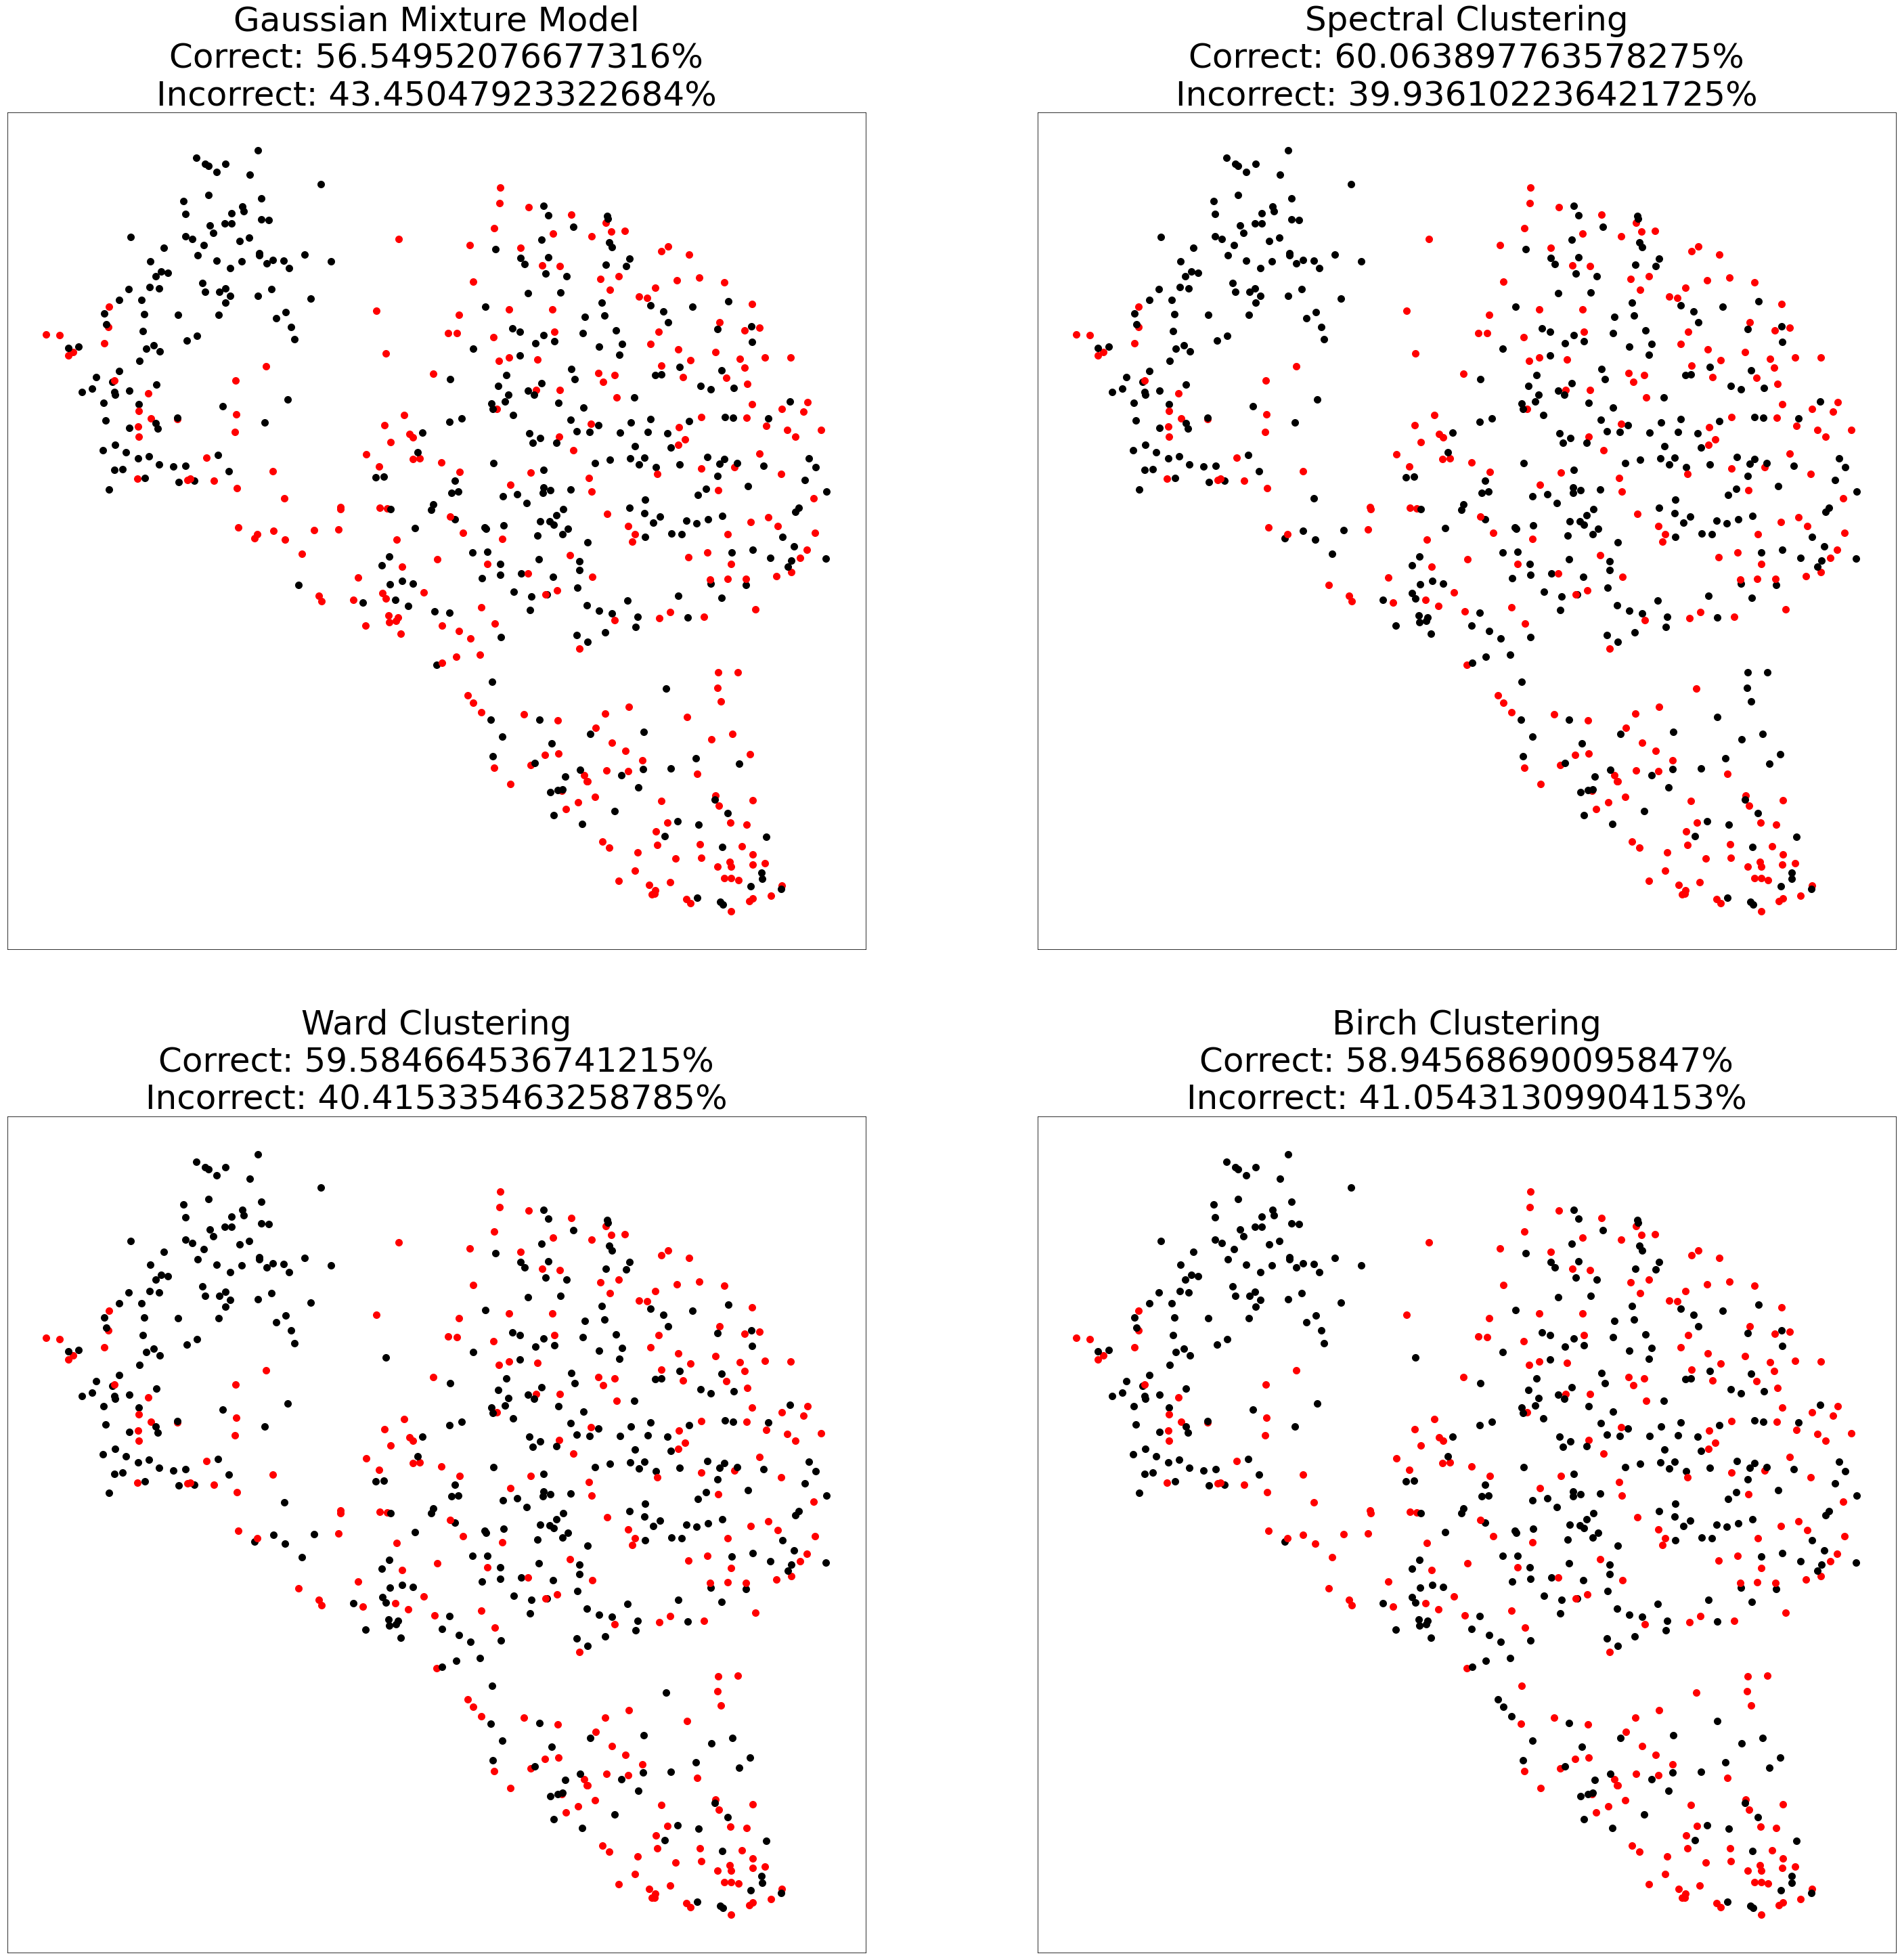

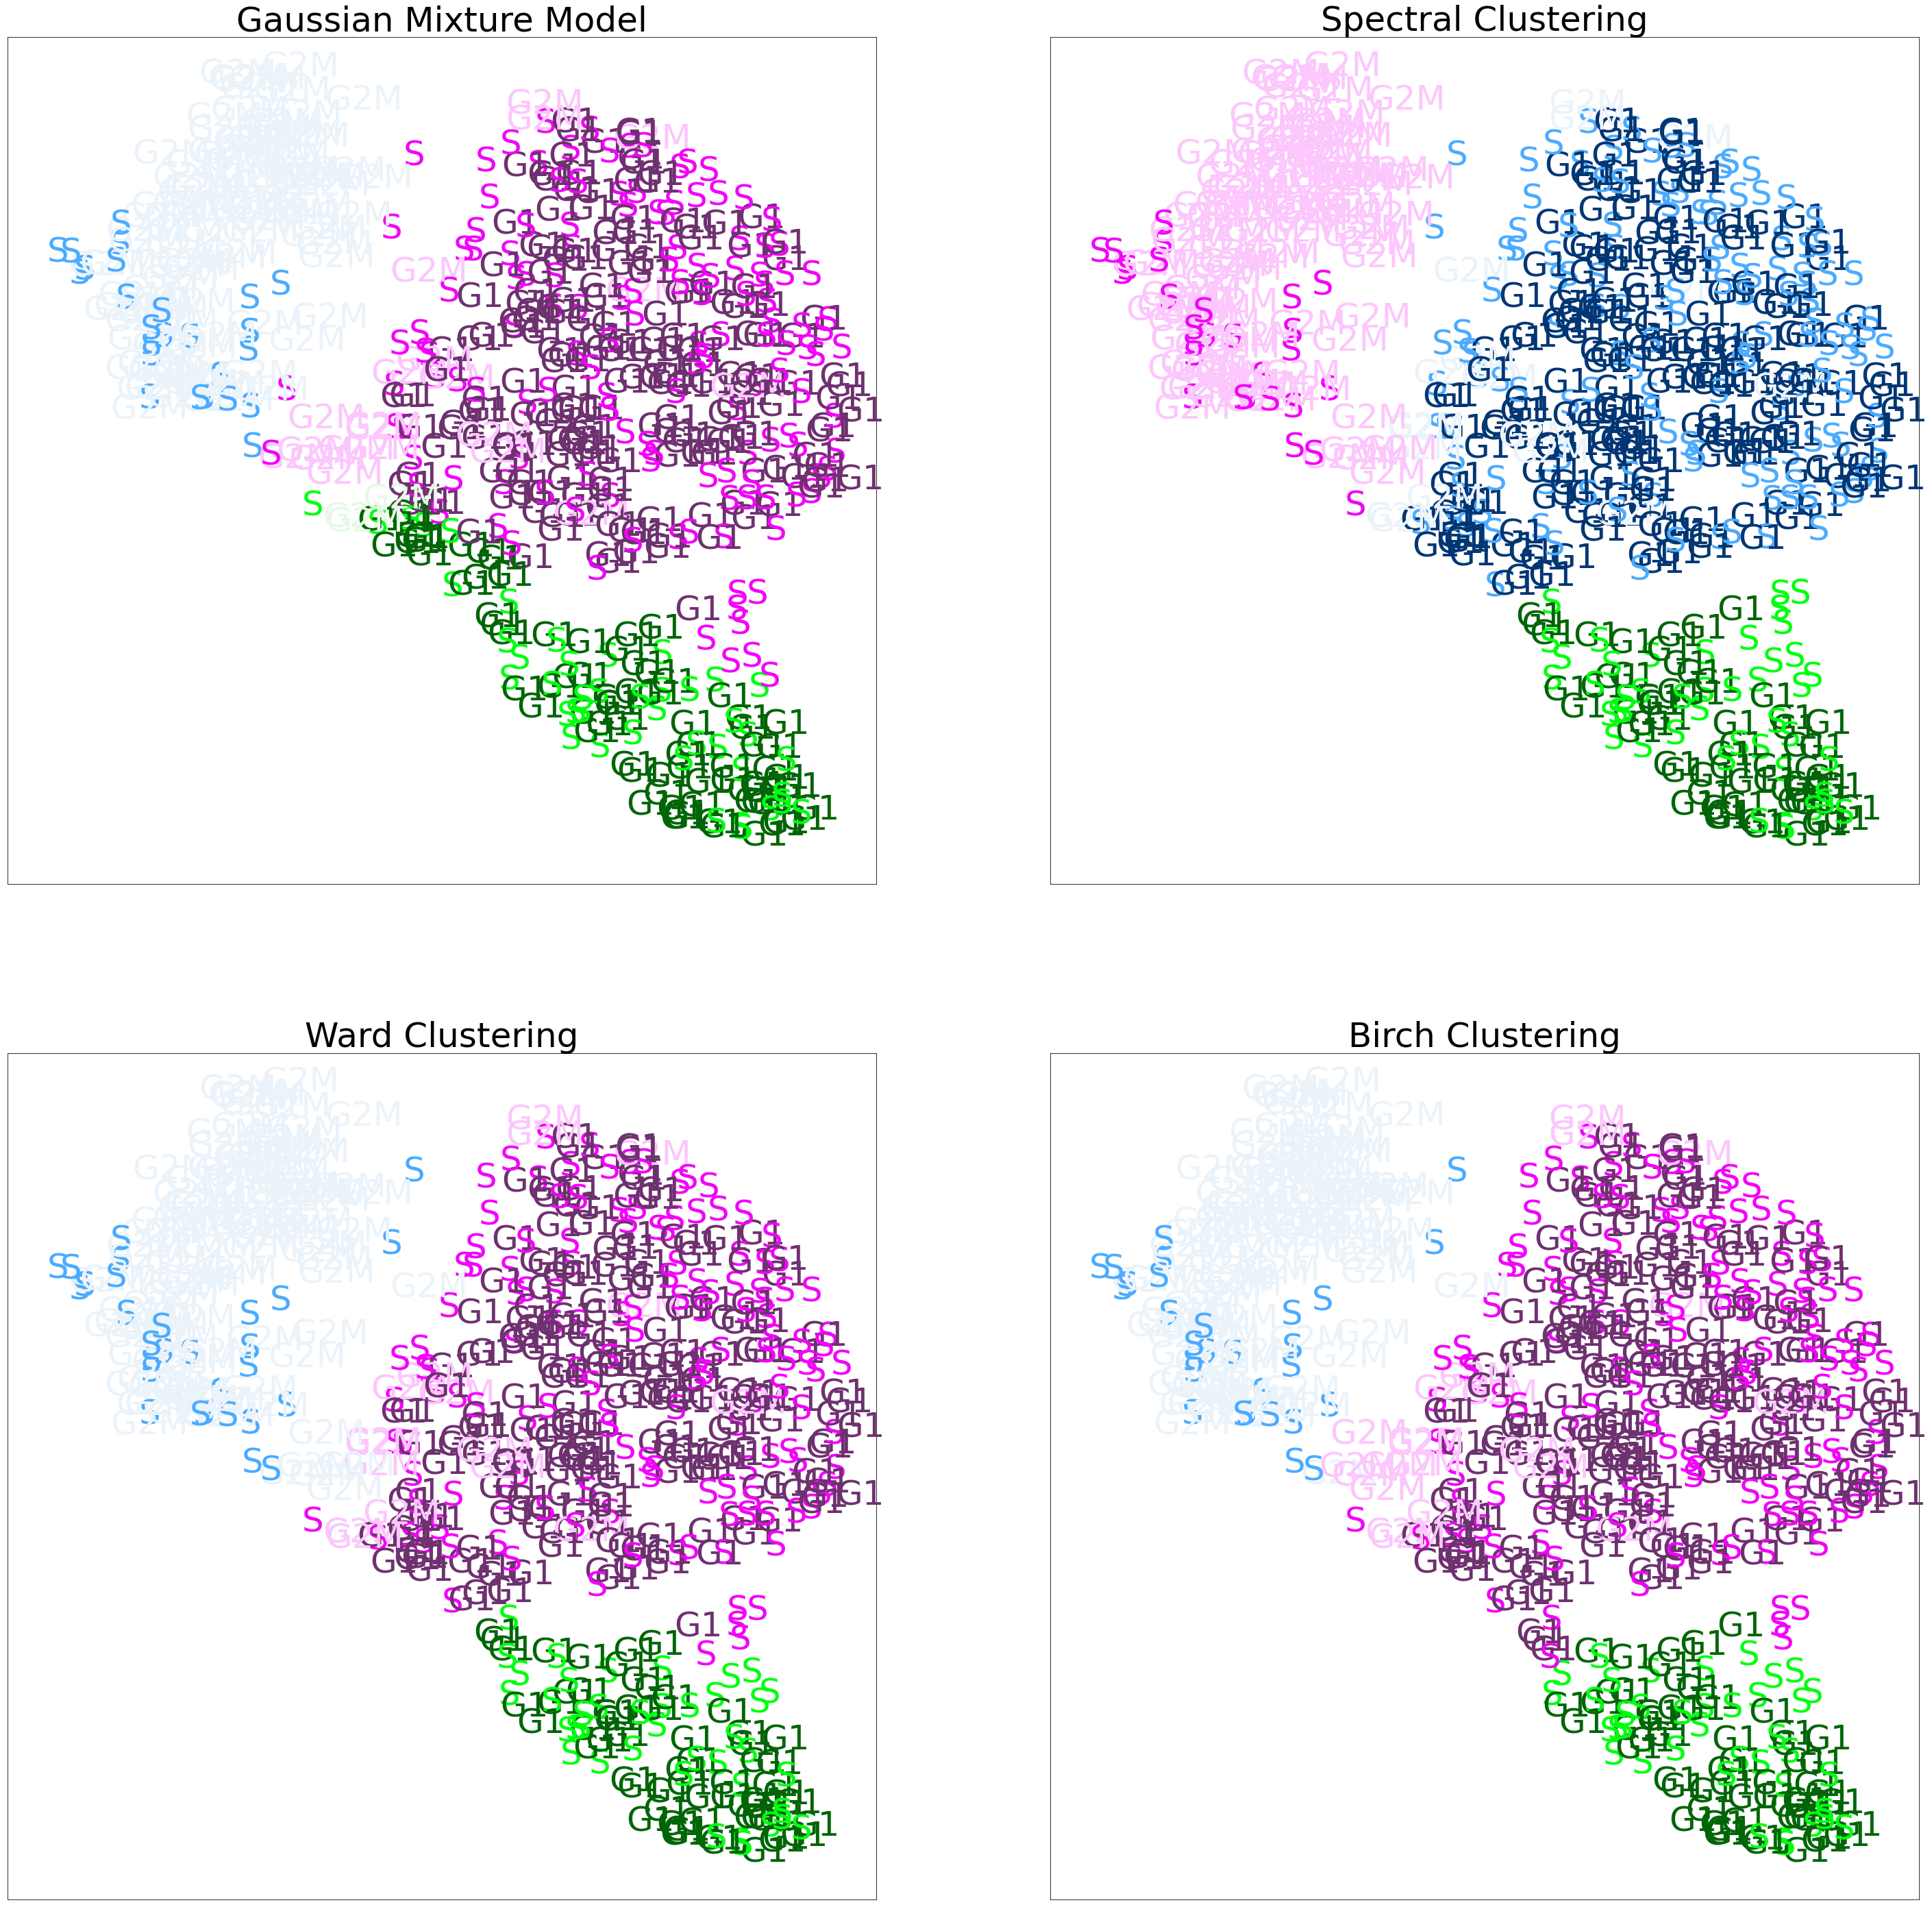

In [16]:
def DataViz(figname, algorithm, cluster1, cluster2, cluster3, results):
    fig, ax = plt.subplots(2, 2, figsize=(50, 50))
    mpl.rcParams['text.color'] = 'black'
    coloring = []
    for i in range(len(algorithm)):
        truthnum1, truthnum2 = DataCollection(algorithm[i], cluster1[i], cluster2[i], cluster3[i], results[i])
        for j in truthnum1:
            coloring.append(truthnum1[j])     
        
        ax[i//2, i%2].set_xticks(())
        ax[i//2, i%2].set_yticks(())
        mpl.rcParams['text.color'] = 'black'
        ax[i//2, i%2].set_title(figname[i], size=50)
        for g in range(len(truthnum1)):
#         plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=truthnum1[str(embedding[i]).strip()])
            ax[i//2, i%2].scatter(embedding[g:g+1, 0], embedding[g:g+1, 1], s=2, color="white")
            mpl.rcParams['text.color'] = truthnum1[str(embedding[g]).strip()]
            ax[i//2, i%2].annotate(truthnum2[str(embedding[g]).strip()], xy=(embedding[g:g+1, 0], embedding[g:g+1, 1]), size=50) 
    mpl.rcParams['text.color'] = 'black'
    fig.savefig("DATASET2: CELL PHASE DIAGRAMS.png")

def DataViz2(figname, algorithms, cluster1, cluster2, cluster3, results):
    fig, ax = plt.subplots(2, 2, figsize=(50, 50))
    mpl.rcParams['text.color'] = 'black'
    for i in range(len(algorithms)):
        coloring = []
        truthnum1, correct, incorrect = DataCollectionP(algorithms[i], cluster1[i], cluster2[i], cluster3[i], results[i])
        for g in truthnum1:
            coloring.append(truthnum1[g])   
        ax[i//2, i%2].set_xticks(())
        ax[i//2, i%2].set_yticks(())
        mpl.rcParams['text.color'] = '#000000'
        ax[i//2, i%2].set_title(figname[i] + ("\nCorrect: " + str(correct) + "%" + "\nIncorrect: " + str(incorrect) + "%"), size=50)
        for j in range(len(truthnum1)):
            ax[i//2, i%2].scatter(embedding[j:j+1, 0], embedding[j:j+1, 1], s=100, color=truthnum1[str(embedding[j]).strip()])
    plt.savefig("DATASET2: TRUTH V. PREDICTED.png")
algorithms = [gmm, spectral, ward, birch]
figname = ["Gaussian Mixture Model", "Spectral Clustering", "Ward Clustering", "Birch Clustering"]
cluster1 = ["gmm_cluster1.txt", "spectral_cluster1.txt", "ward_cluster1.txt", "birch_cluster1.txt"]
cluster2 = ["gmm_cluster2.txt", "spectral_cluster2.txt", "ward_cluster2.txt", "birch_cluster2.txt"]
cluster3 = ["gmm_cluster3.txt", "spectral_cluster3.txt", "ward_cluster3.txt", "birch_cluster3.txt"]
results = ["gmm_results.txt", "spectral_results.txt", "ward_results.txt", "birch_results.txt"]
mpl.rcParams['text.color'] = 'black'
DataViz2(figname, algorithms, cluster1, cluster2, cluster3, results)
mpl.rcParams['text.color'] = 'black'
DataViz(figname, algorithms, cluster1, cluster2, cluster3, results)

#DataViz2("Test42", spectral, "spectral_cluster1.txt", "spectral_cluster2.txt", "spectral_cluster3.txt", "spectral_results.txt")
#DataViz("Spectral Truth Plot.png", spectral, "spectral_cluster1.txt", "spectral_cluster2.txt", "spectral_cluster3.txt", "spectral_results.txt")
#DataViz("Birch Truth v. Predicted Plot.png", birch, "birch_cluster1.txt", "birch_cluster2.txt", "birch_cluster3.txt", "birch_results.txt")
#DataViz("Ward Truth v. Predicted Plot.png", ward, "ward_cluster1.txt", "ward_cluster2.txt", "ward_cluster3.txt", "ward_results.txt")
#DataViz("Birch True Cell Phase Plot.png", birch, "birch_cluster1.txt", "birch_cluster2.txt", "birch_cluster3.txt", "birch_results.txt")
#DataViz("Spectral Truth v. Predicted Plot.png", spectral, "spectral_cluster1.txt", "spectral_cluster2.txt", "spectral_cluster3.txt", "spectral_results.txt")
